# Vehicle Classification Model

This file contains the code for creatiing, training, and compressing the CNN used for the thesis project.

In [8]:
DATASET_PATH = "seconds_per_frame_0.50,overlap_0.25,mfccs_40_.csv"
INPUT_SHAPE = (40, 16, 1)

MODEL_NAME = "cnn"

GENERATE_KERAS_MODLE = False
KERAS_MODEL_NAME = f"{MODEL_NAME}.h5"  # Try using .keras instead.

TF_LITE_MODEL_FILE_NAME = f"{MODEL_NAME}.tflite"

## Imports

Place all imports in this section.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, 
    InputLayer, GlobalAveragePooling2D, AveragePooling2D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping


/home/fridh/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-03-28 10:04:37.437536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743152677.461532  111780 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743152677.468418  111780 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-28 10:04:37.494269: I tensorflow/core/platform/cpu_feat

In [2]:
print(tf.__version__)

2.18.0


In [3]:
# Modify GPU memory allocator to try to prevent full GPU memory.
# This can in some cases be counter productive!
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

### Connect to Google Drive

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

# Helper Functions

In [5]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [6]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

# Importa Data

In [9]:
df = pd.read_csv(DATASET_PATH, header=None)                     # Note that these should be no header present.
dataset = df.iloc[:, :-1].to_numpy(dtype=np.float16)            # All but last column as float32 (required by MCU)
labels_set = df.iloc[:, -1].to_numpy(dtype=str)                 # Last column as string

In [10]:
largestValue = np.max(dataset)
smallestValue = np.min(dataset)
print("Largest value in dataset: ", largestValue)
print("Smallest value in dataset: ", smallestValue)

Largest value in dataset:  210.2
Smallest value in dataset:  -632.5


In [11]:
# Convert dataset into the range of -128 to 127
dataset = (dataset - smallestValue) / (largestValue - smallestValue) * 255
dataset = dataset.astype(np.int8)  # Convert to int8
print(dataset[0])

[ -97  -99  -98  -96  -95  -94  -93  -91  -92  -95  -95  -96  -95  -96
  -97  -97  -40  -40  -40  -41  -42  -42  -42  -42  -44  -42  -42  -42
  -40  -43  -40  -40  -99 -100 -100 -101 -102 -102 -101 -105 -105 -102
 -103 -103 -103 -103 -101 -101  -51  -54  -53  -51  -49  -49  -49  -49
  -48  -50  -51  -50  -51  -50  -52  -52  -74  -73  -74  -75  -73  -75
  -76  -72  -74  -74  -75  -74  -74  -75  -74  -74  -67  -69  -68  -69
  -70  -69  -68  -67  -69  -69  -70  -70  -71  -70  -69  -69  -60  -61
  -60  -59  -60  -60  -61  -62  -61  -61  -60  -58  -58  -59  -61  -61
  -71  -72  -71  -71  -71  -72  -74  -73  -73  -73  -72  -72  -71  -73
  -72  -72  -58  -59  -59  -58  -58  -57  -57  -56  -58  -59  -60  -60
  -60  -59  -59  -58  -68  -67  -68  -69  -70  -68  -69  -70  -71  -69
  -69  -68  -68  -69  -68  -68  -66  -66  -66  -66  -66  -67  -67  -66
  -66  -65  -66  -67  -67  -66  -66  -65  -63  -63  -62  -61  -61  -61
  -62  -62  -61  -61  -62  -62  -63  -61  -62  -61  -70  -70  -70  -69
  -71 

In [12]:
dataset = dataset.reshape(dataset.shape[0], INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2])

print(f"Dataset shape: {dataset.shape}")
print(f"Labels shape: {labels_set.shape}")
print(f"Input shape: {INPUT_SHAPE}")

Dataset shape: (583554, 40, 16, 1)
Labels shape: (583554,)
Input shape: (40, 16, 1)


In [13]:
x_train, x_test, y_train, y_test = train_test_split(dataset, labels_set, test_size=0.2, random_state=42, stratify=labels_set)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Print the lengths of the training, validation, and testing sets.
print(f"Training set length: {len(x_train)}")
print(f"Validation set length: {len(x_val)}")
print(f"Testing set length: {len(x_test)}")

Training set length: 373474
Validation set length: 93369
Testing set length: 116711


In [14]:
# Calculate class weights (based on training data).
class_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
dist_class_weight = dict(enumerate(class_weight))

In [15]:
print(f"Classes: {np.unique(labels_set)}")
print(f"Class weights: {dist_class_weight}")

# Print out the amount of each class.
unique, counts = np.unique(y_train, return_counts=True)
print(f"Training class distribution: {dict(zip(unique, counts))}")

Classes: ['Background_noise' 'Car' 'Commercial_vehicles' 'Motorcycle']
Class weights: {0: np.float64(2.8794331709122307), 1: np.float64(1.070813358717343), 2: np.float64(0.5228619268418341), 3: np.float64(1.2402499933583062)}
Training class distribution: {np.str_('Background_noise'): np.int64(32426), np.str_('Car'): np.int64(87194), np.str_('Commercial_vehicles'): np.int64(178572), np.str_('Motorcycle'): np.int64(75282)}


In [16]:
# Hot end code the labels.
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train))
y_test = to_categorical(label_encoder.fit_transform(y_test))
y_val = to_categorical(label_encoder.fit_transform(y_val))

## Model


### Helper Functions

In [17]:
def compileModel(model, learning_rate = 0.001):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss = tf.keras.losses.CategoricalCrossentropy(),
        metrics=['categorical_accuracy']
    )
    model.summary()

In [18]:
# Print training history
# Function used for printing two plots, one for accuracy and one for loss.
# To be used with the history object from the fit method
def printHistory(history):
  # Collect the number of epochs run based on the amount of loss value under history.
  epochs = len(history.history['loss'])

  epochrange = range(1, epochs + 1)
  train_acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.plot(epochrange, train_acc, 'bo', label='Training acc')
  plt.plot(epochrange, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochrange, train_loss, 'bo', label='Training loss')
  plt.plot(epochrange, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [19]:
def printConfusionMatrix(model, x_test, y_test, labels_set):
    y_train_int = np.argmax(y_train, axis=1)  # Convert one-hot to integer labels for y_train
    y_test_int = np.argmax(y_test, axis=1)  # Convert one-hot to integer labels for y_test

    y_pred_prob = model.predict(x_test)

    y_pred = np.argmax(y_pred_prob, axis=1)  # Convert softmax probabilities to class indices

    # Ensure that the labels are in 1D arrays (class indices) before passing to confusion_matrix
    print(f"y_train_int shape: {y_train_int.shape}")
    print(f"y_test_int shape: {y_test_int.shape}")
    print(f"y_pred shape: {y_pred.shape}")

    # Define your class labels (ensure they match the number of classes)
    class_names = np.unique(labels_set)  # Assuming labels_set contains class names

    # Generate confusion matrix
    cm = confusion_matrix(y_test_int, y_pred)

    # Visualize the confusion matrix with proper labels
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [20]:
# Fit model function used for convinience when fitting the model multiple times
def fitModel(model, x_train, y_train, x_val, y_val, epochs, doPrintHistory, class_weight, verbose, batch_size):

    # Define early stopping callback.
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        verbose=verbose,
        class_weight=class_weight,
        batch_size=batch_size,
        callbacks=[early_stopping],
    )
    # Print history
    if doPrintHistory: printHistory(history)

In [21]:
def evaluate_tflite_model(model_path, x_test, y_test):

  interpreter = tf.lite.Interpreter(model_path)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  predictions = []
  for i in range(len(x_test)):
    # Set the input tensor.
    interpreter.set_tensor(input_details[0]['index'], [x_test[i]])

    # Run inference.
    interpreter.invoke()

    # Get the output tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(output_data)

  # Convert predictions to class labels
  predicted_labels = [np.argmax(prediction[0]) for prediction in predictions]
  true_labels = [np.argmax(label) for label in y_test]

  # Calculate accuracy
  correct_predictions = sum([1 for true, predicted in zip(true_labels, predicted_labels) if true == predicted])
  accuracy = correct_predictions / len(true_labels)

  # Print the accuracy
  print(f"Accuracy: {accuracy}")

  # Print a classification report
  print(classification_report(true_labels, predicted_labels))

### Create, train, compile, test

In [22]:


model = keras.Sequential([
    InputLayer(shape=INPUT_SHAPE),

    Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    
    Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    
    Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    
    Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    MaxPooling2D(),

    # Feature Pooling (Combining Max & Average Pooling)
    Flatten(),

    # Fully Connected Layer
    Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),

    # Output Layer (Softmax for multi-class classification)
    Dense(units=len(np.unique(labels_set)), activation="softmax") # Softmax barely increase size.
])

2025-03-28 10:06:23.436513: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-03-28 10:06:23.436548: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: Mellon
2025-03-28 10:06:23.436559: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: Mellon
2025-03-28 10:06:23.436681: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.120.0
2025-03-28 10:06:23.436712: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.120.0
2025-03-28 10:06:23.436720: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.120.0


In [23]:
compileModel(model)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 40, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 8, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 8, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 8, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 8, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 4, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 4, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 10, 4, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 5, 2, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 5, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 5, 2, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 169,092 (660.52 KB)

 Trainable params: 168,452 (658.02 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/8
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 394s 67ms/step - categorical_accuracy: 0.4970 - loss: 0.9817 - val_categorical_accuracy: 0.2971 - val_loss: 1.8195
Epoch 2/8
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 390s 67ms/step - categorical_accuracy: 0.5538 - loss: 0.8044 - val_categorical_accuracy: 0.2520 - val_loss: 3.4284
Epoch 3/8
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 399s 68ms/step - categorical_accuracy: 0.5823 - loss: 0.7532 - val_categorical_accuracy: 0.5510 - val_loss: 1.0783
Epoch 4/8
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 395s 68ms/step - categorical_accuracy: 0.6081 - loss: 0.7134 - val_categorical_accuracy: 0.2631 - val_loss: 3.5495
Epoch 5/8
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 395s 68ms/step - categorical_accuracy: 0.6321 - loss: 0.6734 - val_categorical_accuracy: 0.6047 - val_loss: 0.8418
Epoch 6/8
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 395s 68ms/step - categorical_accuracy: 0.6524 - loss: 0.6419 - val_categorical_accuracy: 0.4701 - val_loss: 1.2666
Epoch 7/8
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 398s 68ms/step - catego

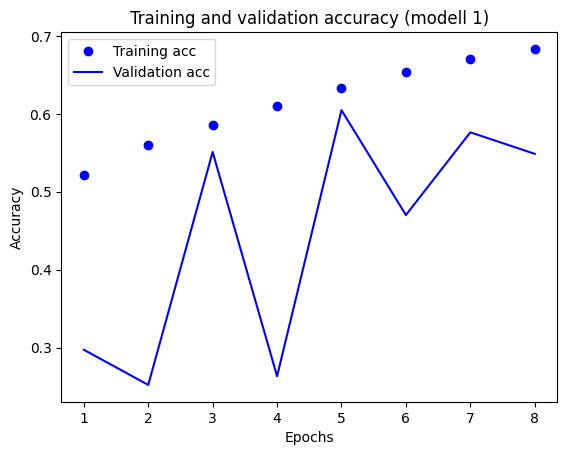

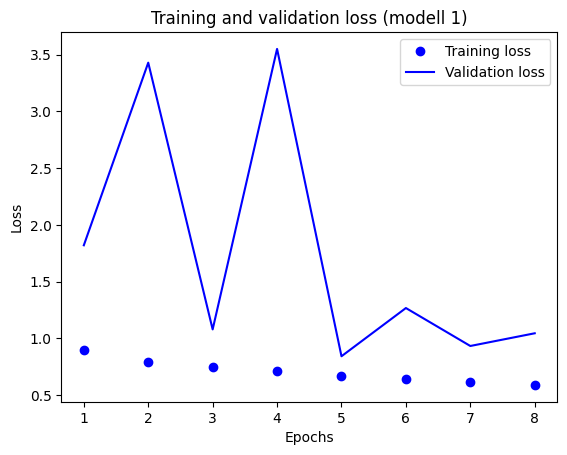

In [24]:
fitModel(model, x_train, y_train, x_val, y_val, 8, True, dist_class_weight, 1, 64)

In [25]:
# Evaluate the model on the test set.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

3648/3648 - 27s - 7ms/step - categorical_accuracy: 0.6056 - loss: 0.8462
Test accuracy: 0.6055898666381836


3648/3648 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step
y_train_int shape: (373474,)
y_test_int shape: (116711,)
y_pred shape: (116711,)


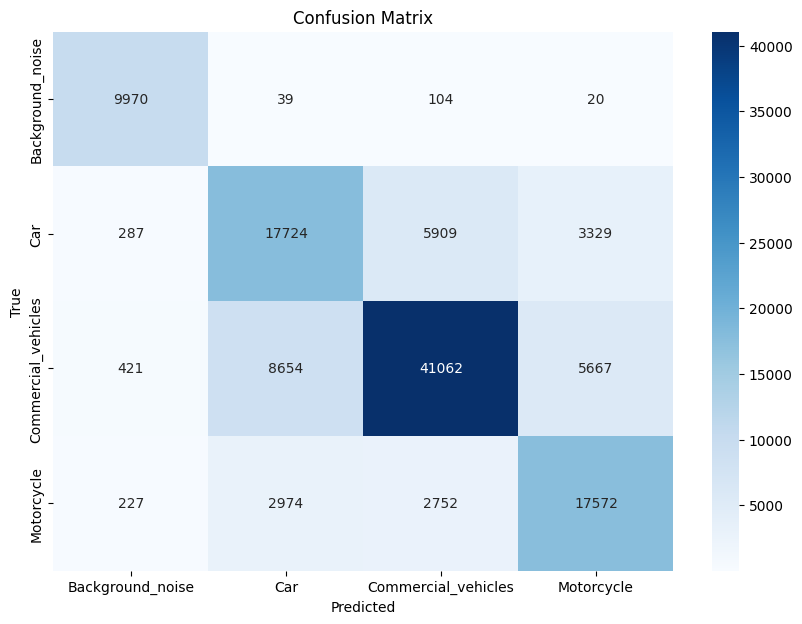

In [23]:
printConfusionMatrix(model, x_test, y_test, labels_set)

# Save & Compress model

### Keras Model

Generating the Keras model is not required, thus the boolean check.

In [24]:
if GENERATE_KERAS_MODLE:
    model.save(KERAS_MODEL_NAME)
    print("Keras model saved: ", KERAS_MODEL_NAME)
    convert_bytes(get_file_size(KERAS_MODEL_NAME), "KB")

### TF Lite model

The TF Lite model is the main model to be used. This is where compression happens and thus also makes it important to test once again after compression. Once done, it's transformed into a CPP file to be implemented into pico-tfmicro.

In [25]:
# Convert into TFLite model.
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply optomizations.
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_converter.target_spec.supported_types = [tf.float32]

# Grab model and save it.
tflite_model = tf_lite_converter.convert()
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

print("TFLite model saved: ", TF_LITE_MODEL_FILE_NAME)
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

# Print model input and output shape for debugging.
interpreter = tf.lite.Interpreter(model_path=TF_LITE_MODEL_FILE_NAME)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

# Evaluate the TFLite model.
evaluate_tflite_model(TF_LITE_MODEL_FILE_NAME, x_test, y_test)

INFO:tensorflow:Assets written to: /tmp/tmp5_szc7mx/assets


INFO:tensorflow:Assets written to: /tmp/tmp5_szc7mx/assets


Saved artifact at '/tmp/tmp5_szc7mx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40, 16, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  134911225332832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134911225337760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134911225346032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134911225347440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134911225341456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134911225343744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134911225342512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134911225580176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134911225581584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134911225581232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134911225581056:

W0000 00:00:1743133328.011726   90761 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1743133328.011751   90761 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-28 04:42:08.012093: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp5_szc7mx
2025-03-28 04:42:08.015270: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-28 04:42:08.015292: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp5_szc7mx
I0000 00:00:1743133328.048351   90761 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-03-28 04:42:08.054410: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-28 04:42:08.260792: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp5_szc7mx
2025-03-28 04:42:08.334507: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

TFLite model saved:  cnn.tflite
File size: 668.77 Kilobytes
Input Shape: [ 1 40 16  1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 4]
Output Type: <class 'numpy.float32'>
Accuracy: 0.7396732098945258
              precision    recall  f1-score   support

           0       0.91      0.98      0.95     10133
           1       0.60      0.65      0.63     27249
           2       0.82      0.74      0.78     55804
           3       0.66      0.75      0.70     23525

    accuracy                           0.74    116711
   macro avg       0.75      0.78      0.76    116711
weighted avg       0.75      0.74      0.74    116711



In [26]:
# Save the TF Lite model as a C++ array using xxd.
# This is required to implement the model using pico-tfmicro.
# Note that the file size from this is larger than the tflite file size,
# but won't increase the story size of the model when implemented in C++.
!xxd -i {TF_LITE_MODEL_FILE_NAME} > {MODEL_NAME}.cpp